<a href="https://colab.research.google.com/github/FMagnani/ManifoldLearning_scripts/blob/main/mnist_coil20/coil20_umap_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coil20 embedding


Script to compute the embedding of the Coil20 dataset (available at https://www.cs.columbia.edu/CAVE/software/softlib/coil-20.php) with UMAP.  
The result of UMAP is the a layout optimized via the minimization of the Cross Entropy cost function, but also the initial state will be computed that corresponds to the spectral embedding of the fuzzy topological weighted graph.  
All is done for various metric distances. By default the distance in the high dimensional space, as the one in the lower space in which data are embedded, is euclidean. Anyway there's the possibility to choose both the high dimensional distance and the metric space in which to embed the results.  
We will experiment some of these possibilities.

## Import data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os.path
import imageio
import glob
import matplotlib.image as img


path = "drive/MyDrive/Benchmark_Datasets/coil-20-proc/"
        
row_list = []

for im_path in glob.glob(path+"*.png"):

    # im_path is like 'data/coil-20-proc/obj9__41.png'
    obj = im_path.split("obj")[1].split("__")[0]
    view = im_path.split("obj")[1].split("__")[1].split('.')[0]
    
    obj = int(obj)
    view = int(view)
    
    im = np.array(imageio.imread(im_path)) # shape = (128,128)
    im = im.reshape(128*128) # shape = (128*128,)

    row = np.array([obj, view])
    row = np.concatenate((row, im))
    
    row_list.append(row)
            
data = pd.DataFrame(row_list) 
data.columns = np.concatenate( (["obj","view"], data.columns[:-2]) )
            
# The real useful data
X = np.array(data[data.columns[2:]])
labels = np.array(data["obj"])


def show_sample(obj, view):
        
    path = "drive/MyDrive/Benchmark_Datasets/coil-20-proc/obj"+str(obj)+"__"+str(view)+".png"
        
    im = img.imread(path)
    plt.imshow(im, cmap="gray")


Mounted at /content/drive/


## Test

In [ ]:
data

,obj,view,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,16344,16345,16346,16347,16348,16349,16350,16351,16352,16353,16354,16355,16356,16357,16358,16359,16360,16361,16362,16363,16364,16365,16366,16367,16368,16369,16370,16371,16372,16373,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,16,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,16,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,16,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,16,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,16,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,16,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1436,16,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1437,16,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1438,15,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
!pip install umap-learn
import umap
import matplotlib.pyplot as plt

n_neighbors = 5

# We try euclidean metric and cosine metric
emb_euc = umap.UMAP(n_neighbors, min_dist=0.3, n_components=2, metric='euclidean').fit_transform(X)
emb_cos = umap.UMAP(n_neighbors, min_dist=0.3, n_components=2, metric='cosine').fit_transform(X)


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


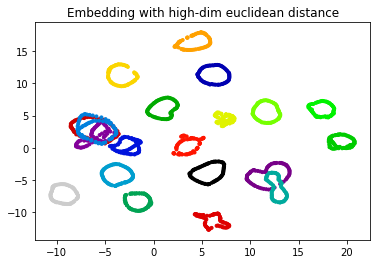

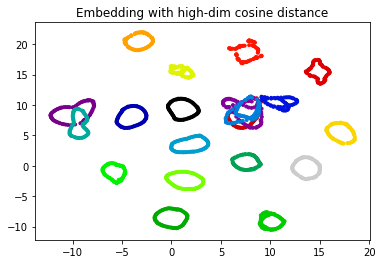

In [ ]:
fig1, ax1 = plt.subplots(1,1)
ax1.scatter(emb_euc[:,0], emb_euc[:,1], c = labels, cmap='nipy_spectral', marker='.')
ax1.set_title("Embedding with high-dim euclidean distance")

fig2, ax2 = plt.subplots(1,1)
ax2.scatter(emb_cos[:,0], emb_cos[:,1], c = labels, cmap='nipy_spectral', marker='.')
ax2.set_title("Embedding with high-dim cosine distance")

plt.show()

Test for embedding in custom low dimensional space.  
Here we give a try to the **cylinder**.

In [ ]:
# Torus distance definition -- https://umap-learn.readthedocs.io/en/latest/embedding_space.html
# Euclidean distance        -- https://github.com/lmcinnes/umap/blob/master/umap/distances.py
# I here employ a cilindrical distance. So it's periodic in one direction but not in the other.

import numba

@numba.njit(fastmath=True)
def cylindrical_2D_grad(x, y, circumference=2*np.pi):
    """Cilindrical distance.
       For 2 dim the code is ok.
       It's toroidal in the first coordinate and euclidean in the second.
    """
    distance_sqr = 0.0
    g = np.zeros_like(x)
    x_dist = abs(x[0] - y[0])
    if 2*x_dist < circumference:
      distance_sqr += x_dist ** 2
      g[0] = (x[0] - y[0])
    else:
      distance_sqr += (circumference-x_dist) ** 2
      g[0] = (x[0] - y[0]) * (x_dist-circumference) / x_dist

    y_dist = abs(x[1] - y[1])
    distance_sqr += y_dist ** 2
    g[1] = (x[1] - y[1])

    distance = np.sqrt(distance_sqr)
    return distance, g/(1e-6 + distance)

In [ ]:
# https://umap-learn.readthedocs.io/en/latest/embedding_space.html

n_neighbors = 5
cylinder_mapper = umap.UMAP(n_neighbors=n_neighbors, output_metric=cylindrical_2D_grad, random_state=42).fit(X)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


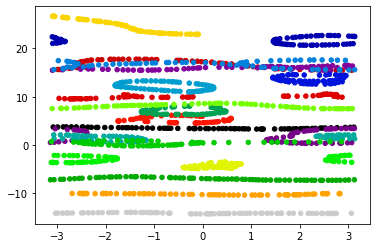

In [ ]:
# Plotting

r = 1 # Radius of the cylinder

# Coordinate change for visualization
x = r * np.cos(cylinder_mapper.embedding_[:, 0])
y = r * np.sin(cylinder_mapper.embedding_[:, 0])
z = cylinder_mapper.embedding_[:, 1]

u = np.arctan2(y,x)
v = z

fig, ax = plt.subplots(1,1)
ax.scatter(u, v, c=labels, cmap='nipy_spectral', s=20)
plt.show()


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

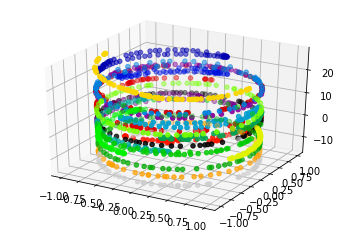

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=labels, cmap='nipy_spectral')
plt.show()

## Embedding computation

In [ ]:
!pip install umap-learn
!pip install pandas
import umap
import scipy.sparse as sparse
from umap.spectral import spectral_layout
import pandas as pd

In [ ]:

n_neighbors_list = [5, 15, 50, 200]

embeddings_df = pd.DataFrame()
embeddings_df["Labels"] = labels

for n_neighbors in n_neighbors_list:

  for (metric, ang) in [('euclidean',False), ('cosine',True)]:

    fuztop_graph, sigmas, rhos = umap.umap_.fuzzy_simplicial_set(
                                                           X,
                                                           n_neighbors = n_neighbors,
                                                           random_state = 123456,
                                                           metric = metric,
                                                           metric_kwds={},
                                                           knn_indices=None,
                                                           knn_dists=None,
                                                           angular=ang,
                                                           set_op_mix_ratio=1.0,
                                                           local_connectivity=1.0,
                                                           apply_set_operations=True,
                                                           verbose=False,
                                                          )

    fuztop_embedding = spectral_layout(X, fuztop_graph, dim=2,
                                       random_state=123456, metric=metric, metric_kwds={})

    umap_embedding = umap.UMAP(n_neighbors=n_neighbors, n_components=2, min_dist=0.3, metric=metric).fit_transform(X)

    embeddings_df["FuzTop_x_"+str(metric)+'_'+str(n_neighbors)] = fuztop_embedding[:,0]
    embeddings_df["FuzTop_y_"+str(metric)+'_'+str(n_neighbors)] = fuztop_embedding[:,1]
    embeddings_df["Umap_x_"+str(metric)+'_'+str(n_neighbors)] = umap_embedding[:,0]
    embeddings_df["Umap_y_"+str(metric)+'_'+str(n_neighbors)] = umap_embedding[:,1]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [ ]:
# Torus distance definition -- https://umap-learn.readthedocs.io/en/latest/embedding_space.html
# Euclidean distance        -- https://github.com/lmcinnes/umap/blob/master/umap/distances.py
# I here employ a cilindrical distance. So it's periodic in one direction but not in the other.

import numba

@numba.njit(fastmath=True)
def cylindrical_2D_grad(x, y, circumference=2*np.pi):
    """Cilindrical distance.
       For 2 dim the code is ok.
       It's toroidal in the first coordinate and euclidean in the second.
    """
    distance_sqr = 0.0
    g = np.zeros_like(x)
    x_dist = abs(x[0] - y[0])
    if 2*x_dist < circumference:
      distance_sqr += x_dist ** 2
      g[0] = (x[0] - y[0])
    else:
      distance_sqr += (circumference-x_dist) ** 2
      g[0] = (x[0] - y[0]) * (x_dist-circumference) / x_dist

    y_dist = abs(x[1] - y[1])
    distance_sqr += y_dist ** 2
    g[1] = (x[1] - y[1])

    distance = np.sqrt(distance_sqr)
    return distance, g/(1e-6 + distance)

In [ ]:
# Ouput metric: cylindrical
cylinder_mapper = umap.UMAP(n_neighbors=5, output_metric=cylindrical_2D_grad, random_state=42).fit(X)

embeddings_df['Cylinder_theta'] = cylinder_mapper.embedding_[:, 0]
embeddings_df['Cylinder_z'] = cylinder_mapper.embedding_[:, 1]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [ ]:
embeddings_df.to_csv("coil20_embeddings.csv")